In [1]:
import copy
import datetime
import pickle
from collections import Counter, defaultdict
from dataclasses import dataclass, field
from pprint import pprint

from flashback_data import Post, AuthorData, load_posts
from imm_loader import ParagraphLoader, ParagraphSample
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

In [2]:
saved_posts = load_posts('../data/saved/index_absa_metadata.json')

post_dict = {post.post_id: post.author_id for post in saved_posts}

In [3]:
authors = defaultdict(AuthorData)
paragrapgh_loader = ParagraphLoader('../data/swe-absa-bank-imm/P_annotation.tsv')
for sample in paragrapgh_loader.samples:
    if sample.document_id in post_dict:
        author_id = post_dict[sample.document_id]
        authors[author_id].paragraphs.append(copy.deepcopy(sample))

print(len(authors), len(saved_posts))

619 1640


In [4]:
sorted_authors = sorted(authors.items(), key=lambda x: len(x[1].paragraphs), reverse=True)
more_than_one_post = [author for author in sorted_authors if len(
    {paragraph.paragraph_id for paragraph in author[1].paragraphs}) > 1]
more_than_two_post = [author for author in sorted_authors if len(
    {paragraph.paragraph_id for paragraph in author[1].paragraphs}) > 2]

number_of_one_posts = sum(
    len({paragraph.paragraph_id for paragraph in author[1].paragraphs}) for author in more_than_one_post)
number_of_two_posts = sum(
    len({paragraph.paragraph_id for paragraph in author[1].paragraphs}) for author in more_than_two_post)

print(len(more_than_one_post), number_of_one_posts)
print(len(more_than_two_post), number_of_two_posts)

491 2188
361 1928


In [5]:
for author, author_data in authors.items():
    author_data.sentiment = sum(paragraph.average
                                for paragraph in set(author_data.paragraphs)) / len(set(author_data.paragraphs))

sentiments = {author_id: author_data.sentiment for author_id, author_data in authors.items()}
sorted_sentiments = list(sorted(authors.items(), key=lambda x: x[1].sentiment))
print([(author, author_data.sentiment) for author, author_data in sorted_sentiments])

[('u524894', 1.0), ('u489312', 1.0), ('u77680', 1.0), ('u719557', 1.0), ('u1037475', 1.0), ('u298547', 1.0), ('u1076154', 1.0), ('u699492', 1.0), ('u361687', 1.0), ('u33122', 1.0), ('u1072500', 1.0), ('u935802', 1.0), ('u657008', 1.0), ('u262447', 1.0), ('u1214429', 1.0), ('u995331', 1.0), ('u690288', 1.0), ('u1009998', 1.0), ('u999910', 1.0), ('u62378', 1.0), ('u1070909', 1.0), ('u436249', 1.0), ('u525756', 1.0), ('u1002923', 1.0), ('u1005656', 1.0), ('u650359', 1.0), ('u540207', 1.0), ('u790073', 1.0), ('u1150103', 1.0), ('u600685', 1.0), ('u273881', 1.0), ('u992462', 1.0), ('u224288', 1.0), ('u1021340', 1.0), ('u1182999', 1.0), ('u1028590', 1.0), ('u946655', 1.0), ('u671119', 1.0), ('u1048283', 1.0), ('u114828', 1.0), ('u448312', 1.0), ('u1054022', 1.0), ('u1031955', 1.0), ('u193082', 1.0), ('u122519', 1.0), ('u331578', 1.0), ('u558623', 1.0), ('u338760', 1.0), ('u1033707', 1.0), ('u471558', 1.0), ('u152434', 1.0), ('u459425', 1.0), ('u682858', 1.0), ('u1167729', 1.0), ('u667774', 1

In [6]:
# bigram_model
number_words = 0
unigram_vocab = Counter()
bigram_vocab = Counter()
for _, author_data in sorted_sentiments:
    for paragraph in author_data.paragraphs:
        unigram_vocab.update(paragraph.tokenized_text)
        bigram_vocab.update(zip(paragraph.tokenized_text[:-1], paragraph.tokenized_text[1:]))
        number_words += len(paragraph.tokenized_text)
print('Number of words:', number_words)
print(f'---{len(unigram_vocab)} unigrams---')
print(unigram_vocab.most_common(20))
print(f'---{len(bigram_vocab)} bigrams---')
print(bigram_vocab.most_common(20))

most_common_bigrams = [bigram for (bigram, _) in bigram_vocab.most_common()]
most_common_unigrams = [unigram for (unigram, _) in unigram_vocab.most_common()]

Number of words: 92789
---12047 unigrams---
[('.', 4623), ('att', 2748), (',', 2338), ('och', 2240), ('i', 1996), ('som', 1935), ('är', 1784), ('det', 1725), ('?', 1272), ('på', 1248), ('en', 1178), ('för', 1135), ('inte', 987), ('till', 924), ('med', 871), ('de', 863), ('har', 843), ('om', 820), ('av', 814), ('jag', 767)]
---53267 bigrams---
[(('?', '.'), 581), (('för', 'att'), 334), (('det', 'är'), 279), (('i', 'sverige'), 251), (('är', 'det'), 217), (('att', 'det'), 188), (('.', 'det'), 175), ((',', 'men'), 154), ((',', 'och'), 137), (('att', 'de'), 136), (('till', 'sverige'), 108), (('sverige', '.'), 106), (('.', 'jag'), 101), ((')', '.'), 93), (('.', 'men'), 90), (('är', 'en'), 88), (('på', 'att'), 87), (('att', 'vi'), 83), (('att', 'man'), 82), (('de', 'som'), 81)]


In [7]:
for _, author_data in sorted_sentiments:
    author_unigram_frequency = Counter()
    author_bigram_frequency = Counter()
    for paragraph in author_data.paragraphs:
        author_unigram_frequency.update(paragraph.tokenized_text)
        author_bigram_frequency.update(zip(paragraph.tokenized_text[:-1], paragraph.tokenized_text[1:]))

    for unigram in most_common_unigrams:
        if unigram in author_unigram_frequency:
            prob = author_unigram_frequency[unigram] / author_unigram_frequency.total()
        else:
            prob = 0
        author_data.unigram_distribution.append(prob)

    for bigram in most_common_bigrams:
        if bigram in author_bigram_frequency:
            prob = author_bigram_frequency[bigram] / author_unigram_frequency[bigram[0]]
        else:
            prob = 0
        author_data.bigram_distribution.append(prob)

In [8]:
pprint([(author_id, author_data.bigram_distribution[:5]) for author_id, author_data in sorted_sentiments][:10])
print(sum(1 for prob in authors['u997331'].bigram_distribution if prob != 0))

[('u524894', [0, 0.5, 0.125, 0, 0.3333333333333333]),
 ('u489312', [0.375, 0, 0, 0.25, 0.3333333333333333]),
 ('u77680', [0, 0, 0, 0, 0]),
 ('u719557', [0, 0, 0.5, 0, 0]),
 ('u1037475', [0, 0, 0, 0, 0]),
 ('u298547', [0.5, 0, 0, 0, 0]),
 ('u1076154', [0, 0, 0, 0, 0]),
 ('u699492', [0.25, 0.6666666666666666, 0.2, 0, 0.2]),
 ('u361687', [0, 0, 0, 0, 0]),
 ('u33122', [0, 0.25, 0.2, 0, 0])]
262


In [9]:
pprint([(author_id, author_data.unigram_distribution[:5]) for author_id, author_data in sorted_sentiments][:10])
print(sum(1 for prob in authors['u997331'].unigram_distribution if prob != 0))

[('u524894',
  [0.0211864406779661,
   0.03389830508474576,
   0.038135593220338986,
   0.03389830508474576,
   0.00847457627118644]),
 ('u489312',
  [0.05128205128205128,
   0.046153846153846156,
   0.02564102564102564,
   0.010256410256410256,
   0.020512820512820513]),
 ('u77680',
  [0.041666666666666664,
   0.020833333333333332,
   0.08333333333333333,
   0.020833333333333332,
   0.08333333333333333]),
 ('u719557',
  [0.0660377358490566,
   0.02830188679245283,
   0.05660377358490566,
   0.009433962264150943,
   0.009433962264150943]),
 ('u1037475', [0.0625, 0.0625, 0, 0, 0]),
 ('u298547',
  [0.058823529411764705, 0.058823529411764705, 0, 0, 0.058823529411764705]),
 ('u1076154',
  [0.04225352112676056,
   0.014084507042253521,
   0,
   0.056338028169014086,
   0.014084507042253521]),
 ('u699492',
  [0.017167381974248927,
   0.04291845493562232,
   0.04721030042918455,
   0.02145922746781116,
   0.017167381974248927]),
 ('u361687',
  [0.05,
   0.016666666666666666,
   0.083333333333

In [10]:
bigram_distributions = [author_data.bigram_distribution for _, author_data in sorted_sentiments]
bigram_cosine_similarity = cosine_similarity(bigram_distributions)
print(bigram_cosine_similarity)

[[1.00000000e+00 1.22011009e-02 0.00000000e+00 ... 0.00000000e+00
  1.50122382e-02 2.01149911e-03]
 [1.22011009e-02 1.00000000e+00 4.56334703e-03 ... 2.54055897e-02
  4.48607139e-03 2.90422833e-04]
 [0.00000000e+00 4.56334703e-03 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 8.74477157e-03]
 ...
 [0.00000000e+00 2.54055897e-02 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.50122382e-02 4.48607139e-03 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [2.01149911e-03 2.90422833e-04 8.74477157e-03 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [11]:
max_value = -1
min_value = 1
for row in bigram_cosine_similarity:
    for value in row:
        if value < 0.99 and value > 0.001:
            max_value = max(max_value, value)
            min_value = min(min_value, value)
    
print(min_value, max_value)

0.001000096590396887 0.1889822365046136


<Figure size 2000x1000 with 0 Axes>

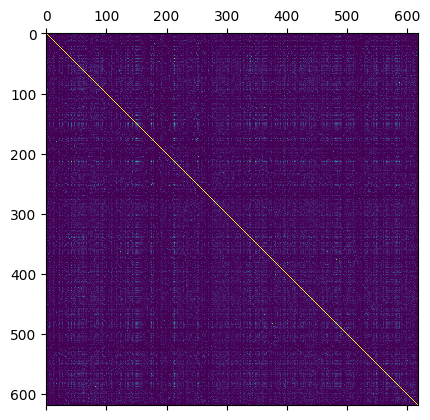

In [12]:
plt.figure(figsize=(20,10))
plt.matshow(bigram_cosine_similarity, vmin=0.001, vmax=0.18)
plt.show()

In [13]:
unigram_distributions = [author_data.unigram_distribution for _, author_data in sorted_sentiments]
unigram_cosine_similarity = cosine_similarity(unigram_distributions)
print(unigram_cosine_similarity)

[[1.         0.47548338 0.25498133 ... 0.18689146 0.29747346 0.52616275]
 [0.47548338 1.         0.38162883 ... 0.38097008 0.49165386 0.54374859]
 [0.25498133 0.38162883 1.         ... 0.21452527 0.26306768 0.30900642]
 ...
 [0.18689146 0.38097008 0.21452527 ... 1.         0.2146971  0.32639244]
 [0.29747346 0.49165386 0.26306768 ... 0.2146971  1.         0.45790547]
 [0.52616275 0.54374859 0.30900642 ... 0.32639244 0.45790547 1.        ]]


In [14]:
max_value = -1
min_value = 1
for row in unigram_cosine_similarity:
    for value in row:
        if value != 1 and value != 0:
            max_value = max(max_value, value)
            min_value = min(min_value, value)
    
print(min_value, max_value)

0.009062120797117264 1.0000000000000087


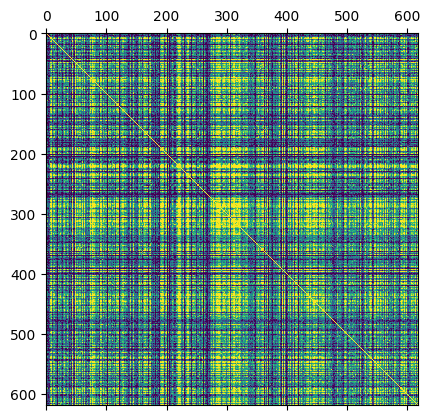

In [15]:
plt.matshow(unigram_cosine_similarity, vmin=0.2, vmax=0.6)
plt.show()